# Burned by Telco Churn

<img src="This_is_Fine.png" alt="No it's not">

In [1]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import itertools

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# classification models
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

# custom modules
import modeling as md
import prepare
import acquire
import exploration
import split

# global variable, will never change
alpha = 0.05

# Project Overview:

## What? 
> * Discover key drivers of churn at Telco                                               
> * Make a predictive model of how likely someone is to churn                               
> * Make recommendations to curb churn                                                   
> * Deliver results in a final report notebook and record predictions.                       

## Why? 
> Find out why customers churn to make data-driven business changes and target our highest areas of opportunity to create the most financial gain/impact.

## How? 
> Acquire data, clean it, explore it, model it.


 # Executive Summary - Findings & Next Steps

### Key Drivers of Churn: Electronic Check, Monthly Charges

### Model:
 - Logistic Regression had the best performance and had **80.67%** accuracy on testing data.
 - Beat baseline accuracy by **9.86%**

### Recommendations: 
- Text reminders of upcoming bills
- Small monthly discounts when enrolled in autopay
- Normalization of monthly charges


### Future Analysis/Action:
* Identify differences in subgroups of customers and determine the reason for variance in monthly cost for churning and non-churning customers.
* Employ measures to reduce the variance in costs to reduce monthly costs for churning customers.                                                                                       
* Conduct a study on the website sign-in and payment system process to see if customers are quitting out at specific spots. 


# Acquire Data

**Acquire Goal:** Queue and save data from the Codeup SQL database for customer data at Telco.

In [2]:
# Queues the sql database for telco data and writes to csv.
# Only reads the csv if it exists
telco_df = acquire.get_telco_data()

# define target variable
target_var = 'churn_Yes'

# show info/standard statistics for the dataframe
print(telco_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   payment_type_id           7043 non-null   int64  
 3   internet_service_type_id  7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

## Acquire keypoints:
   - Wrote SQL to queue the Codeup database, write the results to csv. If csv already
      exists, read from csv instead.
   -  The initial dataframe has 25 columns and 7043 rows.
   -  Both monthly and total charges are the same unit of measure, although tenure is not.
   -  Total charges also has a much higher range than both monthly_charges and tenure.           Scaling might be worth exploring in the future.
   -  Total charges has a datatype of 'object' when it should be float. Fix in prepare.

# Prepare

### Prepare Goals: 
   - Clean data 
   - split into train, validate and test sets
   - Encode sets for model compatability

### Preparing/Cleaning:

In [3]:
# returns clean dataframe, quantitative/categorical columns for 
# future function use. 
telco_df, categories, quant_cols, u_df = prepare.prep_telco(telco_df)

### Data Splitting & Encoding:

In [4]:
# split data into training, validate and test splits, then encode
train, validate, test = split.train_validate_test_split(u_df, 'churn')
train_en, validate_en, test_en = prepare.encode_train_validate_test(u_df, train.drop(columns='customer_id'), 
                                                                    validate.drop(columns='customer_id'),
                                                                    test.drop(columns='customer_id'))

### Unencoded/Encoded Preview:

In [5]:
# unencoded
train.head(2)

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,payment_type,contract_type
5919,5919,8331-ZXFOE,Female,0,No,No,58,Yes,Yes,Yes,...,Yes,No,No,Yes,71.10,4299.20,No,DSL,Credit card (automatic),One year
1915,1915,2790-XUYMV,Male,0,No,Yes,71,Yes,Yes,Yes,...,No,No,No,Yes,85.45,6028.95,No,Fiber optic,Credit card (automatic),One year


In [6]:
# encoded
train_en.head(2)

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check,contract_type_One year,contract_type_Two year,customer_id
5919,0,58,71.10,4299.20,0,0,0,1,0,1,...,1,0,0,0,1,0,0,1,0,8331-ZXFOE
1915,0,71,85.45,6028.95,1,0,1,1,0,1,...,1,0,1,0,1,0,0,1,0,2790-XUYMV


## Preparation Log:
   - There were some 0 values in total_charges that did not add value to the dataset, so they were dropped (7043 -> 7032 rows).
   - Created train, validate and test splits for in-sample testing/exploration, out-of-sample testing, and final model testing.
   - Converted total_charges to 'float64' so it would be possible to do math and to model with it.
   - Encoded each train, validate and test for model compatability.

# Exploration

### Exploration Goals: 
   - Find drivers of churn
   - Ask questions about drivers for insight
   - Visualize and use hypothesis testing to understand our questions
   - Use results to make business recommendations

### Why should we care?

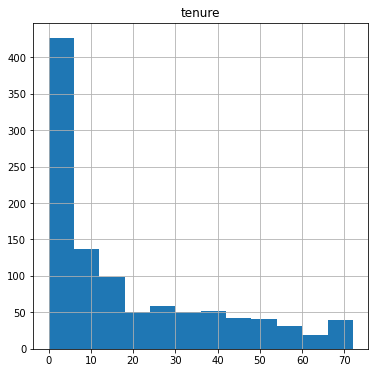

In [7]:
# histogram of tenure and churned
churned = train[train.churn == 'Yes']
six_months = list(range(0,78,6))
churned.tenure.value_counts(bins=six_months)
fig = churned.hist('tenure', bins=six_months, figsize=(6,6))

## Takeaway:

 > Most customers leave within 6 months, and an overwhelming majority leave within the first year -->                                    
   **Addressing key drivers is *urgent***.


### Is Monthly Charges related to Churn?

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

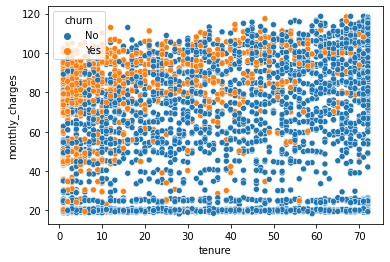

In [8]:
sns.scatterplot(x=train.tenure, y=train.monthly_charges, hue=train.churn)

### Takeaway: 
  > Churning population seems to have higher monthly charges and they tend to leave early.

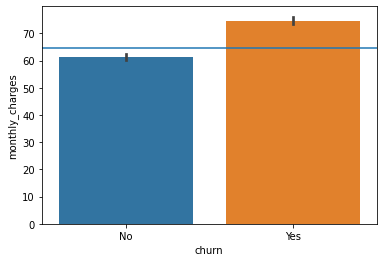

In [9]:
# plots monthly_charges vs churn, adds a mean line
ax= sns.barplot(x=train['churn'], y=train['monthly_charges'])
ax.axhline(train['monthly_charges'].mean())

### Takeaway:
  > Churning population *does* have a higher average monthly charge than non-churning customers.

### Hypothesis Testing:

**Null Hypothesis:** Monthly charges has **no** significant relation to churn.      
**Alternative Hypothesis:** Monthly charges **does** have a significant relation to churn.

In [10]:
observed = pd.crosstab(train.churn, train.monthly_charges)
chi, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print('We reject the Null Hypothesis that monthly charges has no significant relation to churn.')
else:
    print('We accept the Null Hypothesis.')

We reject the Null Hypothesis that monthly charges has no significant relation to churn.


### Takeaway:
  > There's a statistically significant chance that churn and monthly charges are related.  

## Is this problem worse in the first six months?

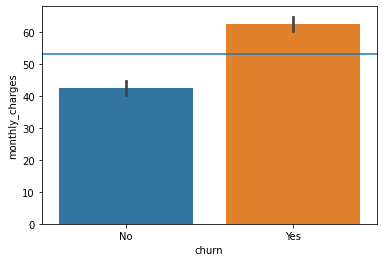

In [11]:
# confine train data to tenure of 6 months or less
six_months = train[train.tenure <= 6]

ax= sns.barplot(x=six_months.churn, y=six_months.monthly_charges)
ax.axhline(six_months.monthly_charges.mean())

### Takeaways:
  > The problem gets worse, going from a difference of about 12 dollars a month between churning and non-churning customers to nearly 20 dollars a month.
 

### Future Analysis/Action for Monthly Charges:
   >  * Identify differences in subgroups of customers and determine if variance in monthly charges for customers with the same service is a common problem.
   >  * Employ measures to reduce the variance in costs to reduce monthly costs for churning customers.

## Is payment type related to churn?

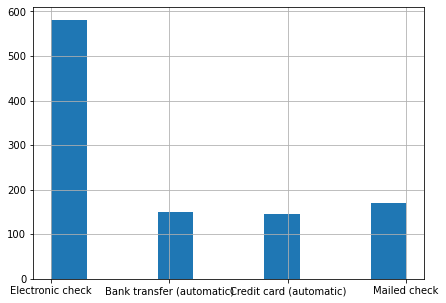

In [12]:
# shows count of churned customers by payment type
churned = train[train.churn == 'Yes']
plt.figure(figsize=(7,5))
payment_type_hist = exploration.target_freq_hist_count(churned, 'payment_type')
plt.show()

**Null Hypothesis:** Payment type has no significant relation to churn.                       
**Alternative Hypothesis:** Payment type does have a significant relation to churn.


In [13]:
observed = pd.crosstab(train.churn, train.payment_type)
chi, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print('We reject the Null Hypothesis that payment type has no significant relation to churn.')
else:
    print('We accept the Null Hypothesis.')

We reject the Null Hypothesis that payment type has no significant relation to churn.


### Takeaways:
  > * There's a statistically significant chance that churn and payment type are related.
  > * Electronic check makes up over 50% of people that churn.

### Recommendations:
 > * Incentivize customers to sign up for autopay with small discounts on their monthly bill
 > * Text reminders about upcoming bills
 
### Future Analysis on Payment Type: 
 > * Do a study on the website sign-in and payment system process to see if customers are quitting out at specific spots. 

# Model and Evaluate

In [14]:
# set baseline
md.Results.baseline = (train_en.churn_Yes==0).mean()
print(f'Baseline accuracy (Churn = 0): {round(md.Results.baseline, 4) * 100}%')

Baseline accuracy (Churn = 0): 73.42999999999999%


If I predicted that someone would not churn, I'd have an accuracy of **73.43%**
That is the baseline accuracy that I am trying to outperform.

I'm going to try Logistic Regression, Random Forests, Decision Trees, and KNearest Neighbors to try and create a predicitve classification model.

I've written functions to adjust the parameters for the following:
   - **Decision Trees:**
        - depth
   - **Random Forests:**
        - depth
        - min samples leaf
   - **KNearestNeighbor:**
        - n_neighbors
        - weights (uniform, distance)
   - **Logistic Regression:**
        - C
        - solver (lbgfs, liblinear)
        - fit_intercept, intercept_scaling
        
*Random State set to 123 where possible.*

### Modeling Code:

In [15]:
# create iterations of models, group them into Result objects that I made in modeling.py
dt_mods, rf_mods, knn_mods, lr_mods = md.all_reports(train_en, validate_en, test_en, target_var)
md.Results.total_summary.head()

,model_type,depth,train_accuracy,validate_accuracy,difference,percent_diff,min_samples_leaf,n_nearest_neighbor,C
0,decision_tree,1.0,0.734315,0.734005,0.000311,0.04,NaN,NaN,NaN
1,decision_tree,2.0,0.794006,0.776066,0.017939,2.26,NaN,NaN,NaN
2,decision_tree,3.0,0.794006,0.776066,0.017939,2.26,NaN,NaN,NaN
3,decision_tree,4.0,0.800610,0.777844,0.022766,2.84,NaN,NaN,NaN
4,decision_tree,5.0,0.806960,0.776066,0.030893,3.83,NaN,NaN,NaN


### Highest Performers Summary:

In [16]:
# get highest performing model types while specifying a limiting % diff between train/validate
md.Results.total_summary[md.Results.total_summary.percent_diff < 3.5].groupby('model_type').max()

,depth,train_accuracy,validate_accuracy,difference,percent_diff,min_samples_leaf,n_nearest_neighbor,C
model_type,,,,,,,,
decision_tree,4.0,0.800610,0.777844,0.022766,2.84,NaN,NaN,NaN
knn_uniform,NaN,0.801372,0.775474,0.025898,3.23,NaN,14.0,NaN
logistic_regression,NaN,0.804420,0.796209,0.008211,1.02,NaN,NaN,10.0
random_forests,8.0,0.822200,0.795616,0.027174,3.33,15.0,NaN,NaN


## Takeaways from modeling:
- all models seemed to beat baseline
- knn_distance had so much variance that it wouldn't show up under the limiting condition of 3.5% difference between train and validate.
- My logistic regression model performed best with a validate accuracy of **79.62%**. This model beats baseline accuracy by **8.43%** and is the model I'll use on the test set.

# Test best Model

In [17]:
logit = LogisticRegression(C=10, random_state=123, fit_intercept=False, intercept_scaling=7.5)
x_train = train_en.drop(columns=[target_var, 'customer_id'])
y_train = train_en[target_var]

logit = logit.fit(x_train, y_train)

X_test = test_en.drop(columns=[target_var, 'customer_id'])
Y_test = test_en[target_var]

y_pred_test = logit.predict(X_test)

accuracy = logit.score(X_test, Y_test)
print(f'Model Accuracy: {round(accuracy * 100, 2)}%')

Model Accuracy: 80.67%


## Test Result Takeaways:
   >> Accuracy of **80.67%** against test set, beating baseline by **9.86%**.

# Create Predictions csv

* Saving the results of our models predictions using customer_id, the outcome prediction for each customer, and the probability that a customer will churn.

In [18]:
proba_test = logit.predict_proba(X_test)
churn_proba = proba_test[:,1]

predictions = pd.DataFrame()
predictions['customer_id'] = test_en.customer_id
predictions['prediction'] = y_pred_test
predictions['probability'] = churn_proba

predictions.to_csv('predictions.csv')

# Conclusions & Recommendations

**Conclusion:** Monthly charges and payment type are both drivers of churn. More analysis is needed to discover why churning customers are saddled with higher monthly charges and why people paying via electronic check are churning more than other payement types.

### Model:
 - Logistic Regression had the best performance and had **80.67%** accuracy on testing data.
 - Beat baseline accuracy by **9.86%**

### Recommendations: 
- Text reminders of upcoming bills
- Small monthly discounts when enrolled in autopay
- Normalization of monthly charges


### Future Analysis/Action:
* Identify differences in subgroups of customers and determine the reason for variance in monthly cost for churning and non-churning customers.
* Employ measures to reduce the variance in costs to reduce monthly costs for churning customers.                                                                                       
* Conduct a study on the website sign-in and payment system process to see if customers are quitting out at specific spots. 